# Lab : Sentiment analysis on IMDB movie reviews

## Objectives

1. Implement a simple way to represent text data - Bag of words
2. Use these representations with a simple classification model for a sentiment analysis task.
3. Implement different ways of obtaining dense representations of the same data
4. Use a logistic regression model to train a classifier on these new representations.

## Necessary dependancies

We will need the following packages:
- The Machine Learning API Scikit-learn : http://scikit-learn.org/stable/install.html
- The Natural Language Toolkit : http://www.nltk.org/install.html
- Gensim: https://radimrehurek.com/gensim/auto_examples/index.html

All are available with Anaconda: https://anaconda.org/anaconda/nltk and https://anaconda.org/anaconda/scikit-learn

In [1]:
import os.path as op
import re 
import numpy as np
import matplotlib.pyplot as plt

## I Classification of IMDB Data in sentiment

### I.1 Loading data

We retrieve the textual data in the variable *texts*.

The labels are retrieved in the variable $y$ - it contains *len(texts)* of them: $0$ indicates that the corresponding review is negative while $1$ indicates that it is positive.

In [2]:
from glob import glob
# We get the files from the path: ./aclImdb/train/neg for negative reviews, and ./aclImdb/train/pos for positive reviews
train_filenames_neg = sorted(glob(op.join('.', 'aclImdb', 'train', 'neg', '*.txt')))
train_filenames_pos = sorted(glob(op.join('.', 'aclImdb', 'train', 'pos', '*.txt')))


# Each files contains a review that consists in one line of text: we put this string in two lists, that we concatenate
train_texts_neg = [open(f, encoding="utf8").read() for f in train_filenames_neg]
train_texts_pos = [open(f, encoding="utf8").read() for f in train_filenames_pos]
train_texts = train_texts_neg + train_texts_pos

# The first half of the elements of the list are string of negative reviews, and the second half positive ones
# We create the labels, as an array of [1,len(texts)], filled with 1, and change the first half to 0
train_labels = np.ones(len(train_texts), dtype=int)
train_labels[:len(train_texts_neg)] = 0.

In [3]:
open("./aclImdb/train/neg/0_3.txt", encoding="utf8").read()

"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly."

**In this lab, the impact of our choice of representations upon our results will also depend on the quantity of data we use:** try to see how changing the parameter ```k``` affects our results !

In [4]:
# This number of documents may be high for most computers: we can select a fraction of them (here, one in k)
# Use an even number to keep the same number of positive and negative reviews
k = 10
train_texts_reduced = train_texts[0::k]
train_labels_reduced = train_labels[0::k]

print('Number of documents:', len(train_texts_reduced))

Number of documents: 2500


Increasing the value of 'k' will decrease the number of samples in the dataset, and thus the training time. However, it will also decrease the quality of the representations we will obtain.

We can use a function from sklearn, ```train_test_split```, to separate data into training and validation sets:

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
train_texts_splt, val_texts, train_labels_splt, val_labels = train_test_split(train_texts_reduced, train_labels_reduced, test_size=.2)

### I.2 Adapted representation of documents

Our statistical model, like most models applied to textual data, uses counts of word occurrences in a document. Thus, a very convenient way to represent a document is to use a Bag-of-Words (BoW) vector, containing the counts of each word (regardless of their order of occurrence) in the document. 

If we consider the set of all the words appearing in our $T$ training documents, which we note $V$ (Vocabulary), we can create **an index**, which is a bijection associating to each $w$ word an integer, which will be its position in $V$. 

Thus, for a document extracted from a set of documents containing $|V|$ different words, a BoW representation will be a vector of size $|V|$, whose value at the index of a word $w$ will be its number of occurrences in the document. 

We can use the **CountVectorizer** class from scikit-learn to obtain these representations:

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin

In [8]:
corpus = ['I walked down down the boulevard',
          'I walked down the avenue',
          'I ran down the boulevard',
          'I walk down the city',
          'I walk down the the avenue']

# We create a CountVectorizer object, and fit it to our corpus
vectorizer = CountVectorizer()
# We transform our corpus to a bag of words representation
Bow = vectorizer.fit_transform(corpus)
# We can see the vocabulary, with the get_feature_names_out() method
print(vectorizer.get_feature_names_out())
Bow.toarray()

['avenue' 'boulevard' 'city' 'down' 'ran' 'the' 'walk' 'walked']


array([[0, 1, 0, 2, 0, 1, 0, 1],
       [1, 0, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 1, 1, 0],
       [1, 0, 0, 1, 0, 2, 1, 0]])

We display the list containing the words ordered according to their index (Note that words of 2 characters or less are not counted).

#### Preprocessing the text: get the BoW representations ##

The first thing to do is to turn the review from a string into a list of words. The simplest method is to divide the string according to spaces with the command:
``text.split()``

But we must also be careful to remove special characters that may not have been cleaned up (such as HTML tags if the data was obtained from web pages). Since we're going to count words, we'll have to build a list of tokens appearing in our data. In our case, we'd like to reduce this list and make it uniform (ignore capitalization, punctuation, and the shortest words). 
We will therefore use a function adapted to our needs - but this is a job that we generally don't need to do ourselves, since there are many tools already adapted to most situations. 
For text cleansing, there are many scripts, based on different tools (regular expressions, for example) that allow you to prepare data. The division of the text into words and the management of punctuation is handled in a step called *tokenization*; if needed, a python package like NLTK contains many different *tokenizers*.

In [9]:
# We might want to clean the file with various strategies:
def clean_and_tokenize(text):
    """
    Cleaning a document with:
        - Lowercase        
        - Removing numbers with regular expressions
        - Removing punctuation with regular expressions
        - Removing other artifacts
    And separate the document into words by simply splitting at spaces
    Params:
        text (string): a sentence or a document
    Returns:
        tokens (list of strings): the list of tokens (word units) forming the document
    """        
    # Lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r"[0-9]+", "", text)
    # Remove punctuation
    REMOVE_PUNCT = re.compile("[.;:!\'?,\"()\[\]]")
    text = REMOVE_PUNCT.sub("", text)
    # Remove small words (1 and 2 characters)
    text = re.sub(r"\b\w{1,2}\b", "", text)
    # Remove HTML artifacts specific to the corpus we're going to work with
    REPLACE_HTML = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    text = REPLACE_HTML.sub(" ", text)
    
    tokens = text.split()        
    return tokens

# Or we might want to use an already-implemented tool. The NLTK package has a lot of very useful text processing tools, among them various tokenizers
# Careful, NLTK was the first well-documented NLP package, but it might be outdated for some uses. Check the documentation !
# import nltk
# nltk.download('punkt')
from nltk.tokenize import word_tokenize

corpus_raw = "I walked down down the boulevard. I walked down the avenue. I ran down the boulevard. I walk down the city. I walk down the the avenue."
print(clean_and_tokenize(corpus_raw))
print(word_tokenize(corpus_raw))

['walked', 'down', 'down', 'the', 'boulevard', 'walked', 'down', 'the', 'avenue', 'ran', 'down', 'the', 'boulevard', 'walk', 'down', 'the', 'city', 'walk', 'down', 'the', 'the', 'avenue']
['I', 'walked', 'down', 'down', 'the', 'boulevard', '.', 'I', 'walked', 'down', 'the', 'avenue', '.', 'I', 'ran', 'down', 'the', 'boulevard', '.', 'I', 'walk', 'down', 'the', 'city', '.', 'I', 'walk', 'down', 'the', 'the', 'avenue', '.']


The next function takes as input a list of documents (each in the form of a string) and returns, as in the example using ``CountVectorizer``:
- A vocabulary that associates, to each word encountered, an index
- A matrix, with rows representing documents and columns representing words indexed by the vocabulary. In position $(i,j)$, one should have the number of occurrences of the word $j$ in the document $i$.

The vocabulary, which was in the form of a *list* in the previous example, can be returned in the form of a *dictionary* whose keys are the words and values are the indices. Since the vocabulary lists the words in the corpus without worrying about their number of occurrences, it can be built up using a set (in python).
<div class='alert alert-block alert-info'>
            Code:</div>

In [10]:
def count_words(texts):
    ''' 
    This function takes a list of texts as input and returns a vocabulary dictionary and an occurrences matrix.

    Params:
        texts (list of strings): a list of documents
    Returns:
        vocabulary (dictionary): a dictionary of words and their index in the occurrences matrix
        occurrences (numpy array): a matrix of shape (len(texts), len(vocabulary)) containing the number of occurrences of each word in each document
    
    '''

    vocabulary = {}
    occurrences = []

    # create vocabulary dictionary
    for text in texts:
        tokens = clean_and_tokenize(text)
        for token in tokens:
            if token not in vocabulary:
                vocabulary[token] = len(vocabulary) 
    
    # create occurrences matrix
    for text in texts:
        tokens = clean_and_tokenize(text)
        occurrence = np.zeros(len(vocabulary), dtype=int)
        for token in tokens:
            occurrence[vocabulary[token]] += 1
        
        # save the quantity of word's occurrences in the document
        occurrences.append(occurrence)

    return vocabulary, np.array(occurrences)

In [11]:
Voc, X = count_words(corpus)
print(Voc)
print(X)

{'walked': 0, 'down': 1, 'the': 2, 'boulevard': 3, 'avenue': 4, 'ran': 5, 'walk': 6, 'city': 7}
[[1 2 1 1 0 0 0 0]
 [1 1 1 0 1 0 0 0]
 [0 1 1 1 0 1 0 0]
 [0 1 1 0 0 0 1 1]
 [0 1 2 0 1 0 1 0]]


Now, if we want to represent text that was not available when building the vocabulary, we will not be able to represent **new words** ! Let's take a look at how CountVectorizer does it:

In [12]:
val_corpus = ['I walked up the street']
Bow = vectorizer.transform(val_corpus)
Bow.toarray()

array([[0, 0, 0, 0, 0, 1, 0, 1]])

Modify the ```count_words``` function to be able to deal with new documents when given a previously obtained vocabulary ! 
<div class='alert alert-block alert-info'>
            Code:</div>

In [13]:
def count_words(texts, voc = None):
    ''' 
    This function takes a list of texts as input and returns a vocabulary dictionary and an occurrences matrix.

    Params:
        texts (list of strings): a list of documents
        voc (dictionary): an initial vocabulary dictionary (default None)
    Returns:
        vocabulary (dictionary): a dictionary of words and their index in the occurrences matrix
        occurrences (numpy array): a matrix of shape (len(texts), len(vocabulary)) containing the number of occurrences of each word in each document 
    '''
    
    # if no vocabulary is given, create a new one
    if voc == None:
        vocabulary = {}
    else:
        vocabulary = voc
    
    occurrences = []

    # create vocabulary dictionary
    for text in texts:
        tokens = clean_and_tokenize(text)
        for token in tokens:
            if token not in vocabulary:
                vocabulary[token] = len(vocabulary) 
    
    # create occurrences matrix
    for text in texts:
        tokens = clean_and_tokenize(text)
        occurrence = np.zeros(len(vocabulary), dtype=int)
        for token in tokens:
            occurrence[vocabulary[token]] += 1
        
        # save the quantity of word's occurrences in the document
        occurrences.append(occurrence)

    return vocabulary, np.array(occurrences)

In [14]:
voc = {'walked':0, 'walking': 1}
Voc, X = count_words(corpus, voc)
print(Voc)
print(X)

{'walked': 0, 'walking': 1, 'down': 2, 'the': 3, 'boulevard': 4, 'avenue': 5, 'ran': 6, 'walk': 7, 'city': 8}
[[1 0 2 1 1 0 0 0 0]
 [1 0 1 1 0 1 0 0 0]
 [0 0 1 1 1 0 1 0 0]
 [0 0 1 1 0 0 0 1 1]
 [0 0 1 2 0 1 0 1 0]]


<div class='alert alert-block alert-warning'>
            Question:</div>
            
Careful: check the size that the representations are going to have (given the way they are build). What does this imply for the memory use ? What ```CountVectorizer``` argument allows to avoid the issue ? 

In [15]:
# Using our function on the training set
voc, train_bow = count_words(train_texts_splt)
# print the size of the vocabulary and the shape of the occurrences matrix 
print(len(voc))
print(train_bow.shape)

29566
(2000, 29566)


In [18]:
# Do the same with a CountVectorizer: create and fit the vectorizer to the training data
vectorizer = CountVectorizer()
train_bow_cv = vectorizer.fit_transform(train_texts_splt)
print(train_bow_cv.shape)

(2000, 25567)


In [19]:
# Transform the validation data
val_bow_cv = vectorizer.transform(val_texts)
print(val_bow_cv.shape)

(500, 25567)


__Answer:__ We can see that the number of columns of the representations is the size of the vocabulary. If we have a large vocabulary, the representations will be very large and will take up a lot of memory. We can use the argument ```max_features```, only keeping the most frequent words in the vocabulary. This allows us to limit the size of the vocabulary and thus the size of the representations.

### I.3 Experimentation with classification

We are going to use the scikit-learn ```MultinomialNB```, an implementation of the Naive Bayesian model. Experiment on this model with your own representations. Visualize the results with the following tools, and compare with the representations of ```CountVectorizer```:
<div class='alert alert-block alert-info'>
            Code:</div>

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       247
           1       0.86      0.76      0.81       253

    accuracy                           0.81       500
   macro avg       0.82      0.81      0.81       500
weighted avg       0.82      0.81      0.81       500



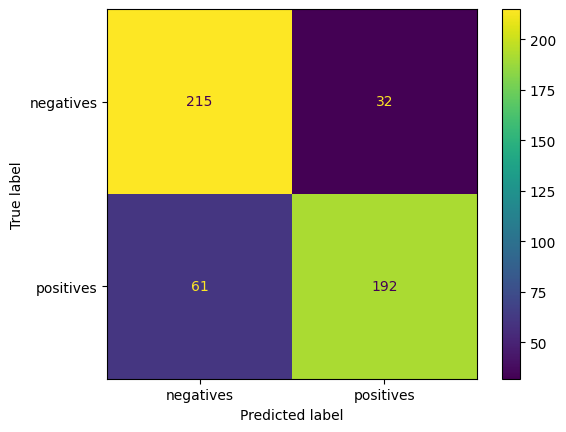

In [20]:
from sklearn.naive_bayes import MultinomialNB

# Using our own implementation

# Fit the model on the training data
clf = MultinomialNB()
clf.fit(train_bow, train_labels_splt)


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
# Test it on the validation data 
val_pred = clf.predict(val_bow[:, :train_bow.shape[1]])
print(classification_report(val_labels, val_pred))
cf_matrix = confusion_matrix(val_labels, val_pred)
cf_disp = ConfusionMatrixDisplay(cf_matrix, 
                                 display_labels=['negatives', 'positives'])
cf_disp.plot()


              precision    recall  f1-score   support

           0       0.76      0.87      0.81       247
           1       0.86      0.73      0.79       253

    accuracy                           0.80       500
   macro avg       0.81      0.80      0.80       500
weighted avg       0.81      0.80      0.80       500



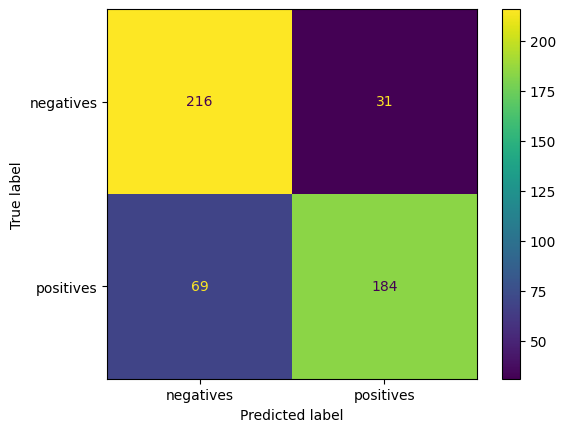

In [21]:
# Same with CountVectorizer representations

# Fit the model on the training data
clf = MultinomialNB()
clf.fit(train_bow_cv, train_labels_splt)

# Test it on the validation data 
val_pred_cv = clf.predict(val_bow_cv)
print(classification_report(val_labels, val_pred_cv))
cf_matrix = confusion_matrix(val_labels, val_pred_cv)
cf_disp = ConfusionMatrixDisplay(cf_matrix, 
                                 display_labels=['negatives', 'positives'])
cf_disp.plot()


<div class='alert alert-block alert-warning'>
            Questions:</div>

- Here, what is the naïve hypothesis ? 
- Let us look at the *features* built by the ```vectorizer```. How can we improve them ? 

In [22]:
print(vectorizer.get_feature_names_out()[:100])

['00' '000' '00001' '007' '01' '02' '05' '06' '07' '08' '09' '10' '100'
 '1000' '1000000' '100m' '101' '102' '105' '10mil' '10th' '10yr' '11'
 '1100' '11001001' '112' '12' '120' '1200f' '123' '125' '12s' '13' '130'
 '134' '13th' '14' '145' '147' '14ieme' '15' '150' '16' '161' '1692'
 '16th' '17' '1794' '1798' '17th' '18' '180' '1824' '1840' '1840s' '1850'
 '1864' '1880' '1880s' '1889' '1892' '1895' '1897' '18th' '19' '1907'
 '1910' '1912' '1914' '1916' '1918' '1919' '1920' '1920s' '1921' '1922'
 '1925' '1927' '1928' '1929' '1930' '1930s' '1931' '1932' '1933' '1934'
 '1935' '1936' '1937' '1938' '1939' '1940' '1940s' '1941' '1942' '1943'
 '1944' '1945' '1946' '1947']


__Answer:__ 

- The naive hypothesis is that the features are independent of each other. This means that the presence or absence of one feature does not affect the presence or absence of other features.
- We can see that in the first 100 features are composed by numbers, there are not informative for the context we are studying. We can remove them by using the argument ```token_pattern``` of ```CountVectorizer```.  

### I.4 Improving representations: by reweighting and filtering

Mainly, the arguments of the class ```vectorizer``` will allow us to easily change the way our textual data is represented. Let us try to work on our *Bag-of-words* representations:
   
#### Do not take into account words that are too frequent:

You can use the argument ```max_df=1.0``` to change the amount of words taken into account. 

#### Try different granularities:

Rather than just counting words, we can count sequences of words - limited in size, of course. 
We call a sequence of $n$ words a $n$-gram: let's try using 2 and 3-grams (bi- and trigrams).
We can also try to use character sequences instead of word sequences.

We will be interested in the options ```analyze='word'``` and ```ngram_range=(1, 2)``` which we'll change to alter the granularity. 

**Again: using these ways of getting more features from our text will probably have more impact if we do not have much training data to begin with !**

To accelerate experiments, use the ```Pipeline``` tool from scikit-learn. 
<div class='alert alert-block alert-info'>
            Code:</div>

In [23]:
from sklearn.pipeline import Pipeline

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       247
           1       0.85      0.81      0.83       253

    accuracy                           0.84       500
   macro avg       0.84      0.84      0.84       500
weighted avg       0.84      0.84      0.84       500



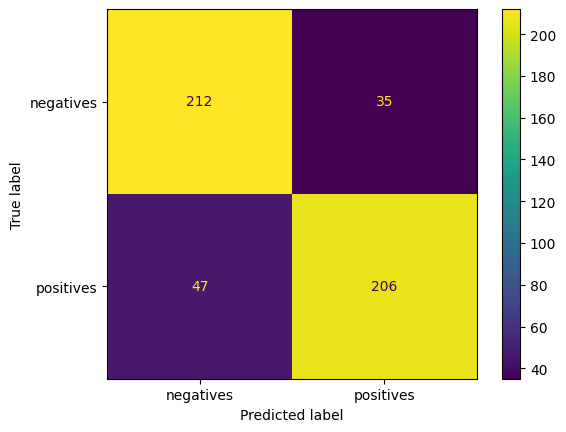

In [24]:
pipeline_base = Pipeline([
    ('vect', CountVectorizer(max_features=30000, analyzer='word',
                              stop_words=None, max_df=1.0, ngram_range=(1, 2))),
    ('clf', MultinomialNB()),
])
pipeline_base.fit(train_texts_splt, train_labels_splt)
val_pred = pipeline_base.predict(val_texts)
print(classification_report(val_labels, val_pred))

cf_matrix = confusion_matrix(val_labels, val_pred)
cf_disp = ConfusionMatrixDisplay(cf_matrix, 
                                 display_labels=['negatives', 'positives'])
cf_disp.plot()


We can see that the results are better with granularities.

#### Tf-idf:

This is the product of the frequency of the term (TF) and its inverse frequency in documents (IDF).
This method is usually used to measure the importance of a term $i$ in a document $j$ relative to the rest of the corpus, from a matrix of occurrences $ words \times documents$. Thus, for a matrix $\mathbf{T}$ of $|V|$ terms and $D$ documents:
$$\text{TF}(T, w, d) = \frac{T_{w,d}}{\sum_{w'=1}^{|V|} T_{w',d}} $$

$$\text{IDF}(T, w) = \log\left(\frac{D}{|\{d : T_{w,d} > 0\}|}\right)$$

$$\text{TF-IDF}(T, w, d) = \text{TF}(X, w, d) \cdot \text{IDF}(T, w)$$

It can be adapted to our case by considering that the context of the second word is the document. However, TF-IDF is generally better suited to low-density matrices, since it will penalize terms that appear in a large part of the documents. 
<div class='alert alert-block alert-info'>
            Code:</div>

In [25]:
from sklearn.preprocessing import normalize

def tfidf(bow):
    """
    Inverse document frequencies applied to our bag-of-words representations
    Params:
        bow (numpy array): a matrix of shape (len(texts), len(vocabulary)) containing the number of occurrences of each word in each document
    Returns:
        tf_idf (numpy array): a matrix of shape (len(texts), len(vocabulary)) containing the tf-idf score of each word in each document

    """
    # IDF
    # the second dimension of bow is the number of documents
    D = bow.shape[1]
    # the frequency of each word in the documents
    doc_freq = np.sum(bow > 0, axis=1)
    idf = np.log(D / doc_freq)
    
    # TF
    # the number of words in each document
    # term_freq = np.sum(bow, axis=0)
    tf = normalize(bow, norm='l1', axis=0) #bow / term_freq

    tf_idf = tf.multiply(idf)


        
    return tf_idf

Experiment with this new representations and compare with the ```TfidfTransformer``` applied on top of ```CountVectorizer```.
<div class='alert alert-block alert-info'>
            Code:</div>

(500, 25567)
              precision    recall  f1-score   support

           0       0.66      0.68      0.67       247
           1       0.68      0.66      0.67       253

    accuracy                           0.67       500
   macro avg       0.67      0.67      0.67       500
weighted avg       0.67      0.67      0.67       500



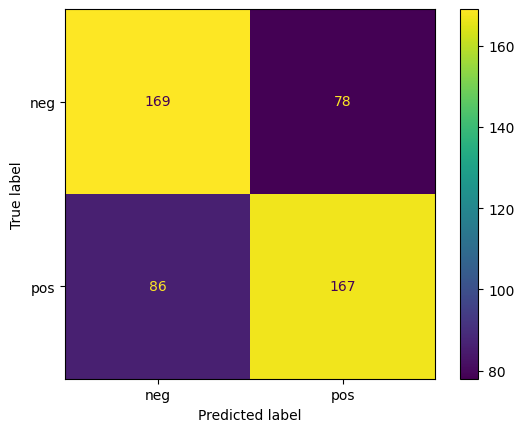

In [26]:
tfidf_train = tfidf(train_bow_cv)
tfidf_val = tfidf(val_bow_cv)

print(tfidf_val.shape)

clf = MultinomialNB()
clf.fit(tfidf_train, train_labels_splt)
val_pred = clf.predict(tfidf_val)
conf_matrix = confusion_matrix(val_labels, val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['neg', 'pos'])
disp.plot()

print(classification_report(val_labels, val_pred))

In [27]:
from sklearn.feature_extraction.text import TfidfTransformer

              precision    recall  f1-score   support

           0       0.80      0.92      0.85       247
           1       0.91      0.77      0.83       253

    accuracy                           0.84       500
   macro avg       0.85      0.84      0.84       500
weighted avg       0.85      0.84      0.84       500



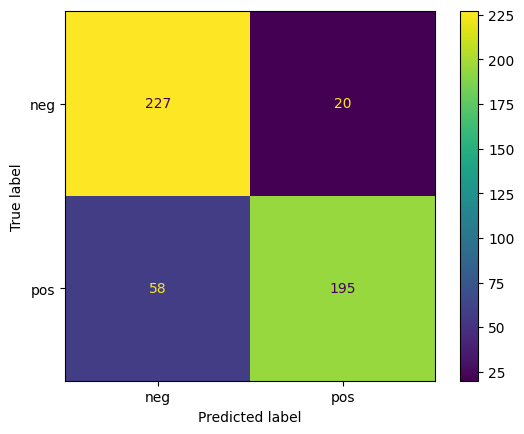

In [28]:
clf = MultinomialNB()
pipeline_tfidf = Pipeline([
    ('vect', CountVectorizer(max_features=30000, stop_words=None, analyzer='word', max_df=1.0, ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
pipeline_tfidf.fit(train_texts_splt, train_labels_splt)
val_pred = pipeline_tfidf.predict(val_texts)
conf_matrix = confusion_matrix(val_labels, val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['neg', 'pos'])
disp.plot()

print(classification_report(val_labels, val_pred))

The classification of positives analyzes was improved while the classification of negative analyzes was degraded with the TF-IDF representation. Making an analysis over f1-score, we got a worse result with TF-IDF representation.

## II Dense Representations 

#### Word Embeddings : Distributed representations via the distributional hypothesis 

**Goal**: We will try to obtain dense representations (as vectors of real numbers) of words (and possibly sentences). These representations are intended to be distributed: they are non-local representations. We represent an object as a combination of *features*, as opposed to the attribution of a dedicated symbol: see the founding work of Geoffrey Hinton, among others, on the subject: [Distributed Representations](https://web.stanford.edu/~jlmcc/papers/PDP/Chapter3.pdf).

The term *distributed* representations is very general, but is what we are looking for. The challenge is therefore to be able to build, automatically, such representations.

**Underlying idea**: It is based on the distributional hypothesis: contextual information is sufficient to obtain a viable representation of linguistic objects.
 - For a large class of cases [...] the meaning of a word is its use in the language." Wittgenstein (Philosophical Investigations, 43 - 1953)
 - You shall know a word by the company it keeps, Firth.

Thus, a word can be characterized by the words that accompany it, via co-occurrence counts. Two words with a similar meaning will have a similar contextual distribution and are therefore more likely to appear in similar contexts. This hypothesis can be used as a justification for the application of statistics to semantics (information extraction, semantic analysis). It also allows some form of generalization: we can assume that the information we have about a word will be generalized to words with a similar distribution. 

**Motivation**: The goal is to obtain distributed representations in order to be able to effectively**:
- Directly perform a semantic surface analysis.
- Use it as a source of information for other language-related models and applications, especially for sentiment analysis. 


**Terminology**: Be careful not to confuse the idea of *distributed* and *distributional* representation. The latter generally indicates (for words) that the representation has been obtained strictly from co-occurrence counts, whereas additional information (document labels, part of speech tags, ...) can be used to build distributed representations. 
The models that allow to build these dense representations, in the form of vectors, are often called *vector spaces models*. These representations are also regularly called *word embeddings*, because the words are embedded in a vector space. In French, we often find the term *word embedding* or *lexical embedding*.

### II.1 Getting representations: counts of occurrences and co-occurrences

Depending on the type of corpus available, different types of distributional information can be obtained. If we have access to a collection of documents, we can thus choose to count the number of occurrences of each word in each document, to obtain a $words \times documents$ matrix: it is on this principle that **Tf-Idf** is built. We will now look at a more general case: we have a large amount of data in text form, and we want to obtain representations of words in the form of vectors of reduced size, without the need to divide them into documents or categories. 

Suppose we have a corpus containing $T$ different words. We will construct a $\mathbf{M}$ matrix of size $T \times T$ which will contain the number of co-occurrences between words. There will be different factors to consider when constructing this matrix: 

- How do you define the 'context' of a word - context which will tell you what terms co-occur with that word?

We can choose to use different scales: the document, the sentence, the nominal group, or simply a window of $k$ words, depending on the information we want to capture.


- Should we keep all the words that appear in the corpus? 

$\rightarrow$ Usually not. We will see that for large corpora, the number $T$ of different words is huge. Second, even if the number of words is reasonable, we will have very little distributional information on the rarest words, and the representation obtained will be of poor quality. We will have to ask ourselves how to filter these words, and how to treat the words we choose not to represent.  

#### Example:

Let's look at the following text:

*I walked down down the boulevard. I walked down the avenue. I ran down the boulevard. I walk down the city. I walk down the the avenue.*

We choose to define the context of a word as the sentence to which it belongs, and to not use any weighting.
We obtain the following matrix: 

|     *         | I | the | down | walked | boulevard | avenue | walk | ran | city |
|---------------|---|-----|------|--------|-----------|--------|------|-----|------|
| I             | 0 |      6 |    6 |   2 |         2 |      2 |   2 |    1 |    1 |
| the           | 6 |      2 |    7 |   2 |         2 |      3 |   3 |    1 |    1 |
| down          | 6 |      7 |    2 |   3 |         3 |      2 |   2 |    1 |    1 |
| walked        | 2 |      2 |    3 |   0 |         1 |      1 |   0 |    0 |    0 |
| boulevard     | 2 |      2 |    3 |   1 |         0 |      0 |   0 |    1 |    0 |
| avenue        | 2 |      3 |    2 |   1 |         0 |      0 |   1 |    0 |    0 |
| ran           | 2 |      3 |    2 |   0 |         0 |      1 |   0 |    0 |    1 |
| walk          | 1 |      1 |    1 |   0 |         1 |      0 |   0 |    0 |    0 |
| city          | 1 |      1 |    1 |   0 |         0 |      0 |   1 |    0 |    1 |

#### In practice: get a Vocabulary.

To begin, we will implement separately a function returning the vocabulary. Here we will have to be able to control its size, by indicating a maximum number of words. We add, at the end, an "unknown" word that will replace all the words that do not appear in our "limited" vocabulary. 

**Remarks:**
- Use tokenization to obtain words from a document !
- Add a special token ```<UNK>``` to deal with out-of-vocabulary words: even if you don't put a limit, you might encounter new words when working with new data. 
- You need to count words and sort them by frequency in order to only keep the most frequent ones. It is not necessary to count 'unknown' words. 

<div class='alert alert-block alert-info'>
            Code:</div>

In [29]:
def vocabulary(corpus, count_threshold=5, voc_threshold=10000):
    """    
    Function using word counts to build a vocabulary - can be improved with a second parameter for 
    setting a frequency threshold
    Params:
        corpus (list of strings): corpus of sentences
        count_threshold (int): number of occurrences necessary for a word to be included in the vocabulary
        voc_threshold (int): maximum size of the vocabulary 
    Returns:
        vocabulary (dictionary): keys: list of distinct words across the corpus
                                 values: indexes corresponding to each word sorted by frequency   
        vocabulary_word_counts (dictionary): keys: list of distinct words across the corpus
                                             values: corresponding counts of words in the corpus
    """

    # Count the number of occurrences of each word in the corpus
    word_counts = {}
    # Loop over each sentence in the corpus
    for sentence in corpus:
        # Convert the sentence to lowercase
        sentence = sentence.lower()
        # Tokenize the sentence
        sentence = word_tokenize(sentence)
        # Loop over each word in the sentence
        for word in sentence:
            # Update the word count
            if word not in word_counts:
                # Initialize the word count
                word_counts[word] = 1
            else:
                # Update the word count
                word_counts[word] += 1

    # Keep only the words that appear at least count_threshold times
    filtered_word_counts = {'UNK': 0}
    for word, count in word_counts.items():
        if count >= count_threshold:
            # Add the word to the vocabulary
            filtered_word_counts[word] = count
        else:
            # if frequency is less than threshold, add to UNK
            filtered_word_counts['UNK'] += count

    # Sort the words by frequency
    # key is used to get sort using values instead of keys
    sorted_word_counts = sorted(filtered_word_counts.items(), key=lambda x: x[1], reverse=True)

    # Keep only the voc_threshold most frequent words
    vocabulary = {}
    vocabulary_word_counts = {}

    # threshold less one because we will add the UNK token
    while len(vocabulary) < (voc_threshold-1) and len(sorted_word_counts) > 0:
        word, count = sorted_word_counts.pop(0)
        vocabulary[word] = len(vocabulary)
        vocabulary_word_counts[word] = count
    if len(vocabulary) >= (voc_threshold-1):
        try:
            vocabulary_word_counts['UNK'] += sum([v for _, v in sorted_word_counts])
        except:
            vocabulary['UNK'] = len(vocabulary)
            vocabulary_word_counts['UNK'] = sum([v for _, v in sorted_word_counts])

    return vocabulary, vocabulary_word_counts

In [30]:
# Example for testing:

corpus = ['I walked down down the boulevard',
          'I walked down the avenue',
          'I ran down the boulevard',
          'I walk down the city',
          'I walk down the the avenue']

voc, counts = vocabulary(corpus, count_threshold = 3)
print(voc)
print(counts)

# We expect something like this:
#  {'down': 0, 'the': 1, 'i': 2, 'UNK': 3}
#  {'down': 6, 'the': 6, 'i': 5, 'UNK': 0}

voc, counts = vocabulary(corpus, count_threshold = 0)
print(voc)
print(counts)

# We expect something like this:
#  {'down': 0, 'the': 1, 'i': 2, 'walked': 3, 'boulevard': 4, 'avenue': 5, 'walk': 6, 'ran': 7, 'city': 8, 'UNK': 9}
#  {'down': 6, 'the': 6, 'i': 5, 'walked': 2, 'boulevard': 2, 'avenue': 2, 'walk': 2, 'ran': 1, 'city': 1, 'UNK': 0}

{'UNK': 0, 'down': 1, 'the': 2, 'i': 3}
{'UNK': 10, 'down': 6, 'the': 6, 'i': 5}
{'down': 0, 'the': 1, 'i': 2, 'walked': 3, 'boulevard': 4, 'avenue': 5, 'walk': 6, 'ran': 7, 'city': 8, 'UNK': 9}
{'down': 6, 'the': 6, 'i': 5, 'walked': 2, 'boulevard': 2, 'avenue': 2, 'walk': 2, 'ran': 1, 'city': 1, 'UNK': 0}


#### Quick study of the data

We would like to get an idea of what's in these film reviews before we proceed. So we'll get the vocabulary (in full) and represent the frequencies of the words, in order (be careful, you'll have to use a logarithmic scale): we should find back Zipf's law. This will give us an idea of the size of the vocabulary we will be able to choose: it's a matter of making a compromise between the necessary resources (size of the objects in memory) and the amount of information we can get from them (rare words can bring a lot of information, but it's difficult to learn good representations of them, because they are rare!).  

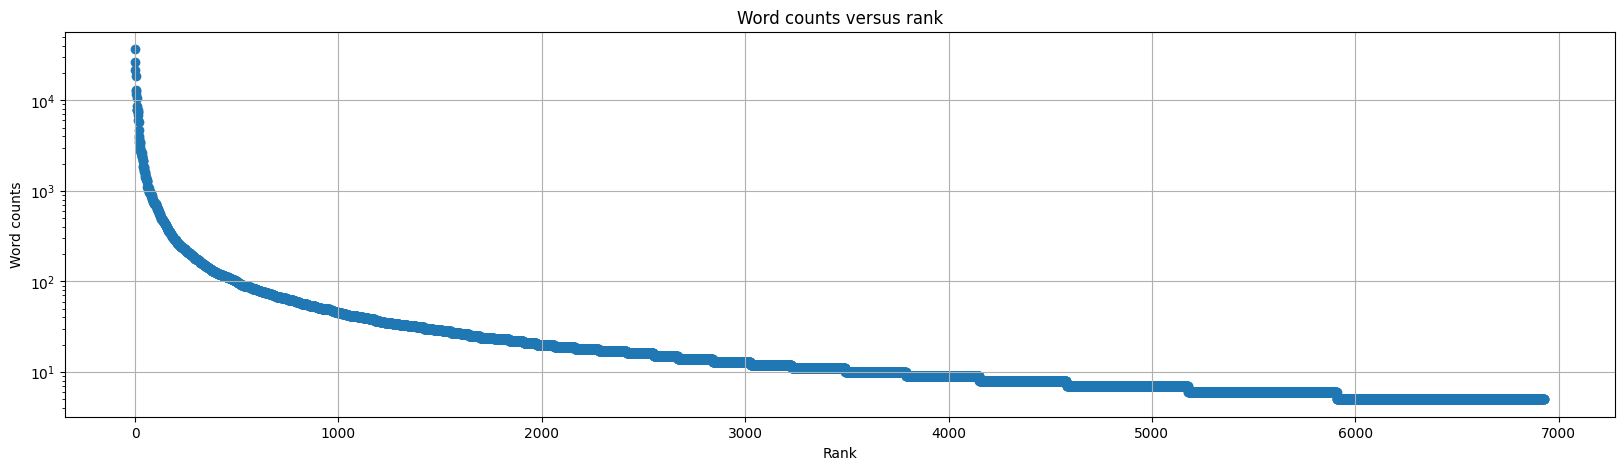

Vocabulary size: 6930


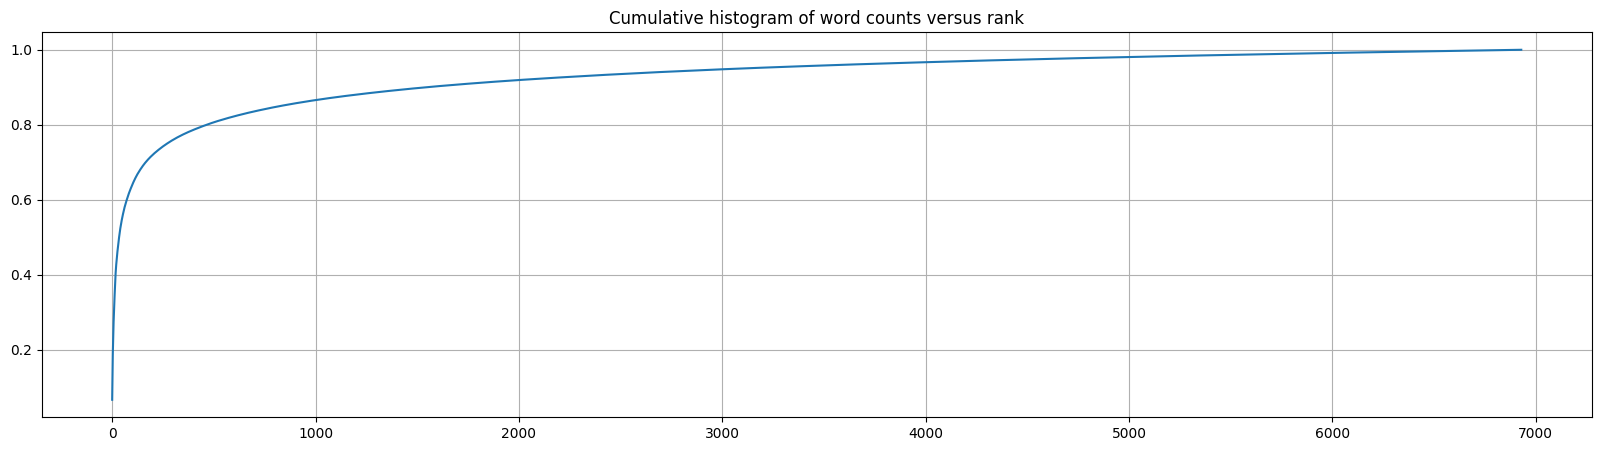

In [31]:
# We would like to display the curve of word frequencies given their rank (index) in the vocabulary
vocab, word_counts = vocabulary(train_texts_splt)
rank = np.arange(len(vocab))
word_counts = np.array(list(word_counts.values()))

# We can for example use the function plt.scatter()
plt.figure(figsize=(20,5))
plt.title('Word counts versus rank')
plt.scatter(rank, word_counts)
plt.xlabel('Rank')
plt.ylabel('Word counts')
plt.yscale('log')
plt.grid()
plt.show()

# We would like to know how much of the data is represented by the 'k' most frequent words
print('Vocabulary size: %i' % len(vocab))
# print('Part of the corpus by taking the "x" most frequent words ?')
plt.figure(figsize=(20,5))
plt.title('Cumulative histogram of word counts versus rank')
# plt.title('Part of the corpus by taking the "x" most frequent words')
plt.plot(np.cumsum(word_counts) / np.sum(word_counts))
plt.grid()
plt.show()

Result of the analysis: you should find that we can be satisfied with 10,000 or even 5,000 words - this is important, because it will determine the size of the objects we will manipulate. 

In [32]:
vocab_5k, word_counts_5k = vocabulary(train_texts, 1, 5000)

In [33]:
print(vocab_5k['cinema'])

448


#### Obtaining co-occurences:

The function takes as input the corpus (a list of strings, corresponding to documents/sentences) and a vocabulary, as well as the size of the context window. We can also implement the simplest solution: the context of a word being the full document to which it belongs. 
Finally, we can implement the possibility of making linearly decrease the importance of the context of a word when getting further from the input word.

**Remark:**
- The matrix we are building is symmetric: we can only build half of it !

<div class='alert alert-block alert-info'>
            Code:</div>

In [34]:
def co_occurence_matrix(corpus, vocabulary, window=0):
    """
    Params:
        corpus (list of list of strings): corpus of sentences
        vocabulary (dictionary): words to use in the matrix
        window (int): size of the context window; when 0, the context is the whole sentence
    Returns:
        matrix (array of size (len(vocabulary), len(vocabulary))): the co-oc matrix, using the same ordering as the vocabulary given in input    
    """ 
    l = len(vocabulary)
    M = np.zeros((l,l))
    for sent in corpus:
        # Get the sentence:
        sent = clean_and_tokenize(sent)
        # Get the indexes of the sentence thanks to the vocabulary 
        sent_idx = [vocabulary[word] for word in sent if word in vocabulary]
        # Look at the indexes of sentence, add 1.0 to the matrix in [i,j] if words 
        # of index i and j appear in the same window
        for i, idx_i in enumerate(sent_idx):
            # With a limited window size:
            if window > 0:
                # On crée une liste qui contient les indexs de la fenêtre à gauche de l'index courant 'idx_i'
                # We create a list containing the indexes of the window to the left of the current index 'idx_i'
                l_ctx_idx = []
                for j in range(max(0, i - window), i):
                    l_ctx_idx.append(sent_idx[j])                    
            # Taking the whole document as context:
            else:
                # The left side context of the word is easier to create
                l_ctx_idx = []
                for j in range(0, i):
                    l_ctx_idx.append(sent_idx[j])
                
            # Update M[i,j]:    
            for j, idx_j in enumerate(l_ctx_idx):
                M[idx_i, idx_j] += 1.0
                M[idx_j, idx_i] += 1.0
    return M  

In [35]:
print(co_occurence_matrix(corpus, voc, 0))

[[2. 7. 0. 3. 3. 2. 2. 1. 1. 0.]
 [7. 2. 0. 2. 2. 3. 3. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [3. 2. 0. 0. 1. 1. 0. 0. 0. 0.]
 [3. 2. 0. 1. 0. 0. 0. 1. 0. 0.]
 [2. 3. 0. 1. 0. 0. 1. 0. 0. 0.]
 [2. 3. 0. 0. 0. 1. 0. 0. 1. 0.]
 [1. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


#### Obtaining the matrices:
We can now get the co-occurence matrices with parameters of our choosing !

In [36]:
vocab_5k, word_counts_5k = vocabulary(train_texts_splt, 0, 5000)
M5 = co_occurence_matrix(train_texts_splt, vocab_5k, window=5)
M20 = co_occurence_matrix(train_texts_splt, vocab_5k, window=20)
print(M5.shape)
print(M20.shape)

(5000, 5000)
(5000, 5000)


### II.2 Vector comparison 

We can use these very large-dimensional vectors for a very simple semantic analysis: for example, by looking for the nearest neighbors of a words. However, we need to be careful to the distance that we use (euclidean, cosine). Vector normalization can also play a role; in any way, we need to not over-interpret this type of results. 

In [37]:
def euclidean(u, v):
    return np.linalg.norm(u-v)

def length_norm(u):
    return u / np.sqrt(u.dot(u))

def cosine(u, v):
    return 1.0 - length_norm(u).dot(length_norm(v))

from sklearn.neighbors import NearestNeighbors

def print_neighbors(distance, voc, co_oc, mot, k=10):
    inv_voc = {id: w for w, id in voc.items()}
    neigh = NearestNeighbors(n_neighbors=k, algorithm='brute', metric=distance)
    neigh.fit(co_oc) 
    dist, ind = neigh.kneighbors([co_oc[voc[mot]]])
    print("Nearest neighbors of '%s' according to distance '%s': " % (mot, distance.__name__), end='\n\n')
    # print("Plus proches voisins de %s selon la distance '%s': " % (mot, distance.__name__))
    print([[inv_voc[i] for i in s[1:]] for s in ind])

print("With a large context, without taking into account the distance between words:")    
#print("Avec un contexte large, sans prendre en compte la distance entre les mots:")    
print_neighbors(euclidean, vocab_5k, M20, 'good')
print_neighbors(cosine, vocab_5k, M20, 'good')
print("\n\n")
print("With a smaller context, and by reducing the impact of word pairs according to their distance:")
# print("Avec un contexte plus petit, et en réduisant l'impact des paires de mots selon leur distance:")    
print_neighbors(euclidean, vocab_5k, M5, 'good')
print_neighbors(cosine, vocab_5k, M5, 'good') 

With a large context, without taking into account the distance between words:
Nearest neighbors of 'good' according to distance 'euclidean': 

[['very', '>', 'time', 'what', 'really', 'more', 'only', 'when', 'even']]


/tmp/ipykernel_10329/538513688.py:5: RuntimeWarning: invalid value encountered in divide
  return u / np.sqrt(u.dot(u))


Nearest neighbors of 'good' according to distance 'cosine': 

[['not', 'really', 'this', 'but', 'just', 'that', 'like', 'very', 'some']]



With a smaller context, and by reducing the impact of word pairs according to their distance:
Nearest neighbors of 'good' according to distance 'euclidean': 

[['very', 'really', 'even', 'some', 'only', 'what', 'just', 'had', 'time']]
Nearest neighbors of 'good' according to distance 'cosine': 

[['great', 'very', 'not', 'really', 'the', 'just', 'that', 'its', 'even']]


/tmp/ipykernel_10329/538513688.py:5: RuntimeWarning: invalid value encountered in divide
  return u / np.sqrt(u.dot(u))


### II.3 Modifying the representations

We may want to alter the representations to obtain better features - depending on what use we will have for them.

**Normalization**: Very easy: we want to cancel the influence of the magnitude of the counts on the representation.

$$\mathbf{m_{normalized}} = \left[ 
   \frac{m_{1}}{\sum_{i=1}^{n}m_{i}}, 
   \frac{m_{2}}{\sum_{i=1}^{n}m_{i}}, 
   \ldots
   \frac{m_{n}}{\sum_{i=1}^{n}m_{i}}, 
\right]$$
 
**Pointwise Mutual Information**: The aim is to assess the extent to which the co-occurrence of the two terms is *unexpected*. This measure is the ratio of the joint probability of the two words and the product of their individual probabilities:
$$
\text{PMI}(x,y) = \log \left( \frac{P(x,y)}{P(x)P(y)} \right)
$$
The joint probability of the two words corresponds to the number of times they are observed together, divided by the total number of co-occurrences in the corpus: 
$$ P(\mathbf{M},w_{1},w_{2}) = \frac{M_{w_{1},w_{2}}}{\sum_{i=1}^{n}\sum_{j=1}^{n} M_{i,j}} $$
The individual probability of a word simply corresponds to its frequency, which can be calculated by counting all co-occurrences where that word appears:
$$ P(\mathbf{M},w) = \frac{\sum_{j=1}^{m} M_{w,j}}{\sum_{i=1}^{n}\sum_{j=1}^{n} M_{i,j}} $$
Hence,
$$ 
\text{PMI}(\mathbf{M},w_{1},w_{2}) = \log  \frac{M_{w_{1},w_{2}} \times \left( \sum_{i=1}^{n}\sum_{j=1}^{n} M_{i,j} \right)}{\left( \sum_{j=1}^{n} M_{w_{1},j} \right) \times \left( \sum_{i=1}^{n}M_{i,w_{2}} \right)} 
$$
We thus calculate the discrepancy between the observation we have made in our corpus and the frequency of appearance of these terms if we consider them independent - i.e. we assume that their co-occurrence is a coincidence.

The main problem with this measure is that it is not adapted to the case where no co-occurrence is observed. Since the PMI is supposed to return a positive quantity if more co-occurrences are observed than expected, and a negative quantity if fewer co-occurrences are observed, we cannot choose to replace $\log(0)$ by $0$. A commonly used solution is to use the **Positive PMI**, which sets all negative values to $0$.
 
 $$\text{PPMI}(\mathbf{M},w_{1},w_{2}) = 
 \begin{cases}
 \text{PMI}(\mathbf{M},w_{1},w_{2}) & \textrm{if } \text{PMI}(\mathbf{M},w_{1},w_{2}) > 0 \\
 0 & \textrm{otherwise}
 \end{cases}$$

In [38]:
def pmi(co_oc, positive=True):
    sum_vec = co_oc.sum(axis=0)
    sum_tot = sum_vec.sum()
    pmi = np.log((co_oc * sum_tot) / (np.outer(sum_vec, sum_vec)))           
    pmi[np.isinf(pmi)] = 0.0  # log(0) = 0
    pmi[np.isnan(pmi)] = 0.0  # 0 / 0 = 0
    if positive:
        pmi[pmi < 0] = 0.0
    return pmi

In [39]:
PPMI5 = pmi(M5)
PPMI20 = pmi(M20)

print("Avec la PPMI:")    
print_neighbors(euclidean, vocab_5k, PPMI5, 'good')
print_neighbors(cosine, vocab_5k, PPMI5, 'good')
print_neighbors(euclidean, vocab_5k, PPMI20, 'good')
print_neighbors(cosine, vocab_5k, PPMI20, 'good')

/tmp/ipykernel_10329/600155074.py:4: RuntimeWarning: invalid value encountered in divide
  pmi = np.log((co_oc * sum_tot) / (np.outer(sum_vec, sum_vec)))
/tmp/ipykernel_10329/600155074.py:4: RuntimeWarning: divide by zero encountered in log
  pmi = np.log((co_oc * sum_tot) / (np.outer(sum_vec, sum_vec)))


Avec la PPMI:
Nearest neighbors of 'good' according to distance 'euclidean': 

[['the', '2/10', '10.', '9/10', '1950', '12', 'd', '1980', 'ai']]


/tmp/ipykernel_10329/538513688.py:5: RuntimeWarning: invalid value encountered in divide
  return u / np.sqrt(u.dot(u))


Nearest neighbors of 'good' according to distance 'cosine': 

[['and', 'very', 'not', 'some', 'are', 'but', 'film', 'was', 'its']]
Nearest neighbors of 'good' according to distance 'euclidean': 

[['and', 'the', 'this', '1950', '1980', 'all.', '10.', '9/10', 'st.']]
Nearest neighbors of 'good' according to distance 'cosine': 

[['acting', 'this', 'are', 'actors', 'and', 'very', 'some', 'bad', 'too']]


/tmp/ipykernel_10329/538513688.py:5: RuntimeWarning: invalid value encountered in divide
  return u / np.sqrt(u.dot(u))


### II.4 Co-occurences matrix : reducing the dimension

#### Motivation

The aim is not only to reduce the size of the data (thus, we will deal with vectors of reduced dimensions, rather than working with vectors of the size of the vocabulary) but also to highlight higher level relationships between words: by reducing their representations to the *most important* dimensions of the data, we *generalize* certain properties between words.

#### Dimension reduction via SVD 

A matrix is a linear transformation: applying an SVD to it means decomposing our linear transformation into a product of linear transformations of different types. In fact, we will change the basis of our vector, and replace our data in a space where each of the coordinates are unchanged by the transformation carried out. Thus, we decompose the matrix $\mathbf{M}$ into three matrices:

$$ \mathbf{M} = \mathbf{U} \mathbf{\lambda} \mathbf{V}^{\text{T}} $$

Matrices $\mathbf{U}$, $\mathbf{\lambda}$, et $\mathbf{V}$ have the following properties:
- $\mathbf{U}$ and $\mathbf{V}$ are orthogonal matrices ($\mathbf{U}^{\text{T}} = \mathbf{U}^{-1}$ and $\mathbf{V}^{\text{T}} = \mathbf{V}^{-1}$). They contain the eigen vectors to the right and to the left of $\mathbf{M}$.
- $\mathbf{\lambda}$ is a diagonal matrix: careful, it's not necessarily square. Values on the diagonal are the eigenvalues of $\mathbf{M}$.

Thus, the *most important* dimensions correspond to the largest eigenvalues. Reducing our data to $k$ dimensions corresponds to keeping only the vectors corresponding to the first $k$ eigenvalues - and this is equivalent to taking the first $k$ vectors of the $U$ matrix. 

Note: When we apply this method to the matrix of $\mathbf{M}$ counts of dimension $T \times D$, where $\mathbf{M}_{t,d}$ contains the number of occurrences of the word $t$ in the document $d$, we obtain the method called **Latent Semantic Analysis**, for the detection of latent (semantic) components allowing the grouping of documents.  

We use ```TruncatedSVD``` from ```scikit-learn```:

In [40]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=300)
SVDEmbeddings = svd.fit_transform(M5)
print(SVDEmbeddings.shape)
SVDEmbeddings[vocab_5k['UNK']]

print_neighbors(euclidean, vocab_5k, SVDEmbeddings, 'good')
print_neighbors(cosine, vocab_5k, SVDEmbeddings, 'good')

(5000, 300)
Nearest neighbors of 'good' according to distance 'euclidean': 

[['very', 'really', 'even', 'some', 'only', 'what', 'just', 'had', 'time']]
Nearest neighbors of 'good' according to distance 'cosine': 

[['great', 'very', 'not', 'really', 'the', 'just', 'that', 'quite', 'its']]


/tmp/ipykernel_10329/538513688.py:5: RuntimeWarning: invalid value encountered in divide
  return u / np.sqrt(u.dot(u))


#### Visualization in two dimensions

We will now use **principal components analysis** (PCA) to visualize our data in two dimensions. This is equivalent to applying SVD to the covariance matrix of the data, in order for the principal components to be independant from each other an maximize the variance of the data. We use the class ```PCA``` from ```scikit-learn```: 

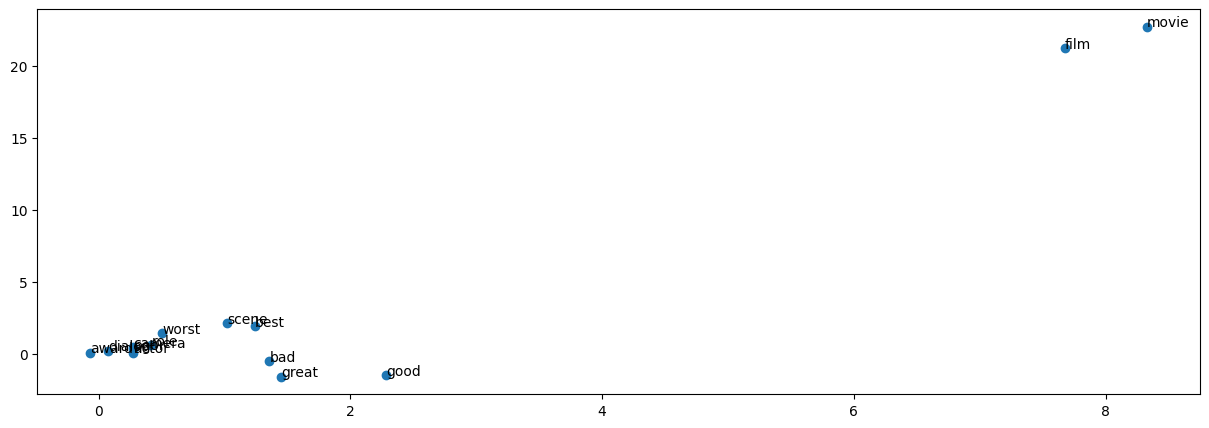

In [41]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)
Emb = pca.fit_transform(M5)

words = ['bad', 'good', 'best', 'worst', 'poor', 'great',
         'dialog', 'role', 'actor', 'camera', 'scene',
         'film', 'movie', 'award']
ind_words = [vocab_5k[w] for w in words]
x_words = [Emb[ind,0] for ind in ind_words]
y_words = [Emb[ind,1] for ind in ind_words]

fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(x_words, y_words)


for i, w in enumerate(words):
    ax.annotate(w, (x_words[i], y_words[i]), (x_words[i] + 0.001, y_words[i] + 0.001))

/tmp/ipykernel_10329/130791600.py:1: RuntimeWarning: invalid value encountered in divide
  Norm5 = M5 / np.linalg.norm(M5, ord=2, axis=1, keepdims=True)


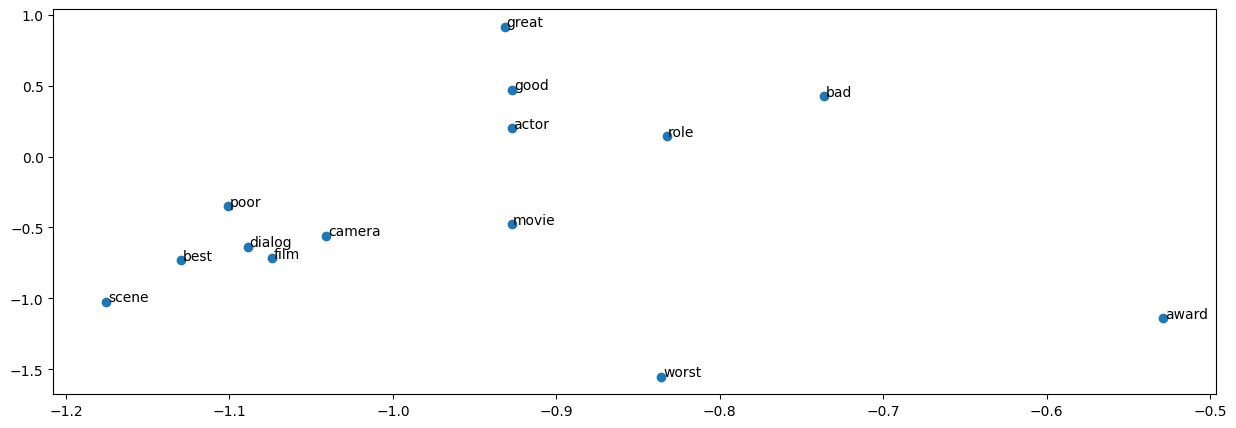

In [42]:
Norm5 = M5 / np.linalg.norm(M5, ord=2, axis=1, keepdims=True)
Norm5[np.isnan(Norm5)] = 0.0

pca = PCA(n_components=2, whiten=True)
Emb = pca.fit_transform(Norm5)

words = ['bad', 'good', 'best', 'worst', 'poor', 'great',
         'dialog', 'role', 'actor', 'camera', 'scene',
         'film', 'movie', 'award']
ind_words = [vocab_5k[w] for w in words]
x_words = [Emb[ind,0] for ind in ind_words]
y_words = [Emb[ind,1] for ind in ind_words]

fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(x_words, y_words)

for i, w in enumerate(words):
    ax.annotate(w, (x_words[i], y_words[i]), (x_words[i] + 0.001, y_words[i] + 0.001))

### II.5 Getting a representation: commonly used algorithms

The idea here is to define a set of representations ${w_{i}}_{i=1}^{V}$, of predefined dimension $d$ (here, we will work with $d = 300$), for all the words $i$ of the vocabulary $V$ - then **train** these representations to match what we want. 

####  Word2Vec: The skip-gram model

The basic skip-gram model tries to predict the context words $c$ surrounding a given center word $w$. Hence, it needs to estimate the probabilities of a pair of words $(i, j)$ to appear together in data:

$$P(j \mid i) = \frac{\exp(w_{i} c_{j})}{\sum_{j'\in V}\exp(w_{i} c_{j'})}$$


where $w_{i}$ is the lign vector (of the word) $i$ representing the center word and $c_{j}$ is the column vector (of one of the context words) $j$. The objective is to minimize the following quantity:


$$ -\sum_{i \in \mathcal{D}} \sum_{j \in \mathcal{N}_i} \sum_{k=1}^{|V|} \textbf{1}\{o_{i}=k\} \log \frac{\exp(w_{i} c_{k})}{\sum_{j=1}^{|V|} \exp(w_{i} c_{j})}$$


where $V$ is the vocabulary. Here, the first sum goes accross words $i$ the dataset $\mathcal{D}$; the second accross context words $j$ in the neighborhood $\mathcal{N}_i$ of word $i$; and the third sums probabilities the context word $j$ being the $k$-th word in the vocabulary for each $k \in V$.
The inputs $w_{i}$ are the representations of the center words, while $c_j$ are representations of the context words; both are made up of parameters, which are updated during training. Note that in this case, those representations are different, and we only keep the $w$ as final word representations to be used in NLP tasks - but it is possible to use the same parameters for $w$ and $c$, or to keep the mean of both representations at the end.  
The **desired output** of the model is an *one-hot* $o$ vector, which contains only one $1$ and $0$. For example, if `good` is the 47th word in the vocabulary, the output $o$ for an example when `good` is the word to predict will consist of $0$s everywhere except $1$ in the 47th position of the vector. `good` will be the word to predict when the input $w$ is a word in its context.
We therefore model this output with standard **softmax**, which will represent a probability distribution over $V$; and we add a bias term $b$. To obtain the vector of output probabilities, we need to vectorialize over all possible context words in $V$ - which means using the full matrix $C$ containing all vectors $c$.

$$ o = \textbf{softmax}(wC + b)$$

Here, we train the parameters contained in $W$ and $C$, two matrices representing the words in reduced dimension (300) using a maximum likelihood objective.

#### Skip-gram with negative sampling

The training of the skip-gram model implies to calculate a sum on the whole vocabulary, because of the *softmax*. As soon as the size of the vocabulary increases, it becomes impossible to compute. In order to make the calculations faster, we change the objective and use the method of *negative sampling* (or, very close to it, the *noise contrastive estimation*).


If here we note $\mathcal{N'}_i$ a set of words that are **not** in the context of the word $i$, the objective is:


$$ \sum_{i \in \mathcal{D}} \sum_{j \in \mathcal{N}_i} -\log\sigma(w_{i}c_{j}) + \sum_{i \in \mathcal{D}} \sum_{j \in \mathcal{N'}_i}\log\sigma(w_{i}c_{j})$$


where $\sigma$ is the sigmoid activation function $\frac{1}{1 + \exp(-x)}$.
In practice, we draw randomly these *negative* words that are not in the context, and we don't differentiate depending on the input word $i$: 

$$ \sum_{i \in \mathcal{D}} \sum_{j \in \mathcal{N}_i} -\log\sigma(w_{i}c_{j}) + \sum_{i \in \mathcal{D}} \sum_{j \in \mathcal{N'}}\log\sigma(w_{i}c_{j})$$

A common practice is to generate pairs from $\mathcal{N}'$ in proportion to the frequencies of the words in the training data (the so-called unigram distribution):


$$P(w) = \frac{\textbf{T}(w)^{0.75}}{\sum_{w'\in V} \textbf{T}(w')}$$


Although different, this new objective function is a sufficient approximation of the previous one, and is based on the same principle. Much research has been done on this objective: for example, [Levy and Golberg 2014](http://papers.nips.cc/paper/5477-neural-word-embedding-as-implicit-matrix-factorization) shows that the objective calculates the PMI matrix shifted by a constant value. One can also see [Cotterell et al. 2017](https://aclanthology.coli.uni-saarland.de/papers/E17-2028/e17-2028) for an interpretation of the algorithm as a variant of PCA.

We will use the ```gensim``` library for its implementation of word2vec in python. We'll have to make a specific use of it, since we want to keep the same vocabulary as before: we'll first create the class, then get the vocabulary we generated above. 
To avoid having to put all the data in memory all at once, we define a generator, which will take all the input data and pre-process it, and return to the ```Word2Vec``` class sentence by sentence. 

In [43]:
from gensim.models import Word2Vec

# For Gensim version 3.8.3
"""
# Creates the Word2Vec model with the relevant parameters
model = Word2Vec(size=300,
                 window=5,
                 iter=30)

# Get the vocabulary from the counts we created earlier
model.build_vocab_from_freq(word_counts_5k)
"""

# Gensim version 4.0.1
model = Word2Vec(vector_size=300,
                 window=5,
                 null_word=len(word_counts_5k),
                 epochs=30)
model.build_vocab_from_freq(word_counts_5k)

In [44]:
# For 3.8.3
"""
def preprocess_generator(large_corpus):
    for line in large_corpus:
        yield clean_and_tokenize(line)
"""
# For 4.0.1
preprocessed_corpus = [clean_and_tokenize(train_texts[i]) for i in range(len(train_texts))]

In [45]:
# For 3.8.3
"""
model.train(preprocess_generator(corpus[:]), total_examples=25000, epochs=30, report_delay=1)
"""

# For 4.0.1
model.train(preprocessed_corpus, total_examples=25000, epochs=30, report_delay=1)

(97323870, 140849190)

In [46]:
W2VEmbeddings = model.wv.vectors

In [47]:
W2VEmbeddings.shape

(5001, 300)

#### The Glove model

The objective defined by Glove ([Pennington et al. (2014)](http://www.aclweb.org/anthology/D/D14/D14-1162.pdf)) is to learn from the vectors $w_{i}$ and $w_{k}$ so that their scalar product corresponds to the logarithm of their **Pointwise Mutual Information**: 


$$ w_{i}^\top w_{k} = (PMI(w_{i}, w_{k}))$$


In the article, this objective is carefully justified by a reasoning about the operations one wants to perform with these vectors and the properties they should have - in particular, symmetry between rows and columns (see the article for more details).  
The final goal obtained is the following, where $M$ is the co-occurrence matrix:


$$\sum_{i, j=1}^{|V|} f\left(M_{ij}\right)
  \left(w_i^\top w_j + b_i + b_j - \log M_{ij}\right)^2$$
  
 
Here, $f$ is a *scaling* function that reduces the importance of the most frequent co-occurrence counts: 


$$f(x) 
\begin{cases}
(x/x_{\max})^{\alpha} & \textrm{if } x < x_{\max} \\
1 & \textrm{otherwise}
\end{cases}$$


Usually, we choose $\alpha=0.75$ and $x_{\max} = 100$, although these parameters may need to be changed depending on the data.

The following code uses the gensim API to retrieve pre-trained representations (It is normal that the loading is long).

In [48]:
import gensim.downloader as api
loaded_glove_model = api.load("glove-wiki-gigaword-300")

We can extract the embedding matrix this way, and check its size:

In [49]:
loaded_glove_embeddings = loaded_glove_model.vectors
print(loaded_glove_embeddings.shape)

(400000, 300)


We can see that there are $400,000$ words represented, and that the embeddings are of size $300$. We define a function that returns, from the loaded model, the vocabulary and the embedding matrix according to the structures we used before. We add, here again, an unknown word "UNK" in case there are words in our data that are not part of the $400,000$ words represented here. 

In [50]:
# For gensim 3.8.3
"""
def get_glove_voc_and_embeddings(glove_model):
    voc = {word : index for word, index in enumerate(glove_model.index2word)}
    voc['UNK'] = len(voc)
    embeddings = glove_model.vectors
    return voc, embeddings
"""

# For gensim 4.0.1
def get_glove_voc_and_embeddings(glove_model):
    voc = {word : index for word, index in enumerate(glove_model.index_to_key)}
    voc['UNK'] = len(voc)
    embeddings = glove_model.vectors
    return voc, embeddings

In [51]:
loaded_glove_voc, loaded_glove_embeddings = get_glove_voc_and_embeddings(loaded_glove_model)

In order to compare the representations loaded here and the ones produced with word2vec, the same vocabulary should be used. For this purpose, I reuse the following code to create a $5000$ word vocabulary from the data, and I add at the end a function that returns the matrix of representations loaded with Glove for these $5000$ words only, in the right order. 

In [52]:
# For gensim 3.8.3
"""
def get_glove_adapted_embeddings(glove_model, input_voc):
    keys = {i: glove_model.vocab.get(w, None) for w, i in input_voc.items()}
    index_dict = {i: key.index for i, key in keys.items() if key is not None}
    embeddings = np.zeros((len(input_voc),glove_model.vectors.shape[1]))
    for i, ind in index_dict.items():
        embeddings[i] = glove_model.vectors[ind]
    return embeddings
"""

# For gensim 4.0.1
def get_glove_adapted_embeddings(glove_model, input_voc):
    keys = {i: glove_model.key_to_index.get(w, None) for w, i in input_voc.items()}
    index_dict = {i: key for i, key in keys.items() if key is not None}
    embeddings = np.zeros((len(input_voc),glove_model.vectors.shape[1]))
    for i, ind in index_dict.items():
        embeddings[i] = glove_model.vectors[ind]
    return embeddings

In [53]:
GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, vocab_5k)

This function takes as input the model loaded using the Gensim API, as well as a vocabulary we created ourselves, and returns the embedding matrix from the loaded model, for the words in our vocabulary and in the right order.
Note: unknown words are represented by a vector of zeros:

In [54]:
print(GloveEmbeddings.shape)
GloveEmbeddings[vocab_5k['UNK']]

(5000, 300)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

### II.6 Application to sentiment analysis

We will now use these representations for sentiment analysis. 
The basic model, as before, will be constructed in two steps:
- A function to obtain vector representations of criticism, from text, vocabulary, and vector representations of words. Such a function (to be completed below) will associate to each word of a review its embeddings, and create the representation for the whole sentence by summing these embeddings.
- A classifier will take these representations as input and make a prediction. To achieve this, we can first use logistic regression ```LogisticRegression``` from ```scikit-learn```  

<div class='alert alert-block alert-info'>
            Code:</div>

In [55]:
def sentence_representations(texts, vocabulary, embeddings, np_func=np.mean):
    """
    Represent the sentences as a combination of the vector of its words.
    Parameters
    ----------
    texts : a list of sentences   
    vocabulary : dict
        From words to indexes of vector.
    embeddings : Matrix containing word representations
    np_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise, 
        like `np.mean`, `np.sum`, or `np.prod`. 
    Returns
    -------
    np.array, dimension `(len(texts), embeddings.shape[1])`            
    """
    representations = np.zeros((len(texts), embeddings.shape[1]))
    for i, text in enumerate(texts):
        words = clean_and_tokenize(text)
        word_inds = [vocabulary.get(w, vocabulary['UNK']) for w in words]
        word_reps = embeddings[word_inds]
        representations[i] = np_func(word_reps, axis=0)    

     
    return representations

In [56]:
from sklearn.linear_model import LogisticRegression

# Exemple with embeddings from Glove
rep = sentence_representations(train_texts_splt, vocab_5k, GloveEmbeddings)
clf = LogisticRegression().fit(rep, train_labels_splt)
rep_test = sentence_representations(val_texts, vocab_5k, GloveEmbeddings)
test_pred = clf.predict(rep_test)
print(clf.score(rep_test, val_labels))

0.81


              precision    recall  f1-score   support

           0       0.80      0.82      0.81       247
           1       0.82      0.80      0.81       253

    accuracy                           0.81       500
   macro avg       0.81      0.81      0.81       500
weighted avg       0.81      0.81      0.81       500



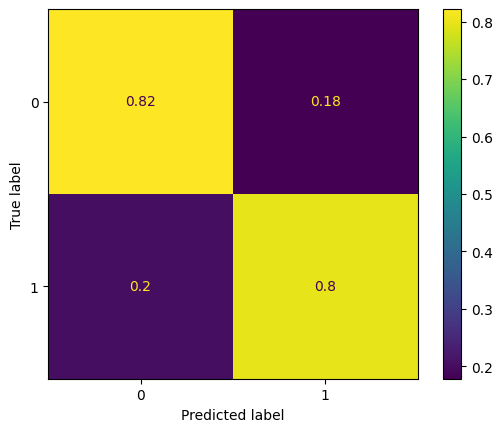

In [57]:
print(classification_report(val_labels, test_pred))
cm = confusion_matrix(val_labels, test_pred, normalize='true')

fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax)
plt.show()

Using Word2Vec embeddings:

In [58]:
rep = sentence_representations(train_texts_splt, vocab_5k, W2VEmbeddings)
clf = LogisticRegression().fit(rep, train_labels_splt)
rep_test = sentence_representations(val_texts, vocab_5k, W2VEmbeddings)
test_pred = clf.predict(rep_test)
print(clf.score(rep_test, val_labels))

0.714


              precision    recall  f1-score   support

           0       0.81      0.83      0.82       247
           1       0.83      0.81      0.82       253

    accuracy                           0.82       500
   macro avg       0.82      0.82      0.82       500
weighted avg       0.82      0.82      0.82       500



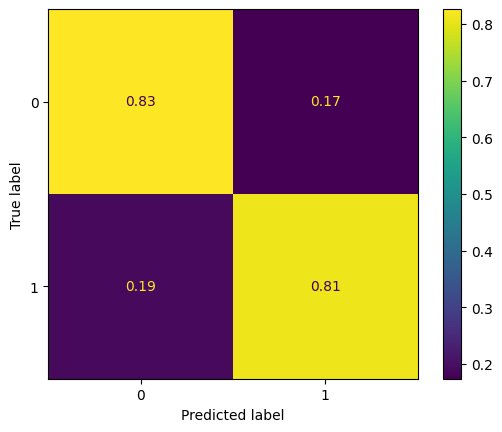

In [64]:
print(classification_report(val_labels, test_pred))
cm = confusion_matrix(val_labels, test_pred, normalize='true')

fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax)
plt.show()

Removing the constraint of having the same 5000 words.

0.818
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       247
           1       0.83      0.81      0.82       253

    accuracy                           0.82       500
   macro avg       0.82      0.82      0.82       500
weighted avg       0.82      0.82      0.82       500



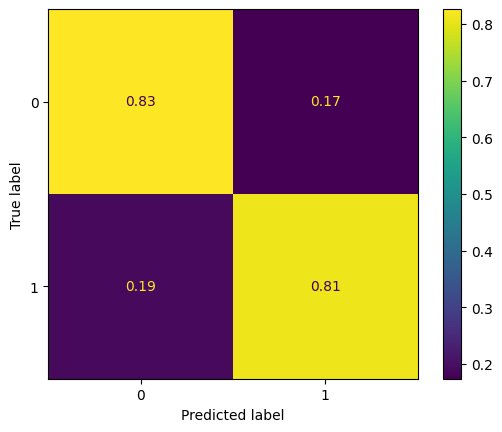

In [65]:
GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, vocab)
rep = sentence_representations(train_texts_splt, vocab, GloveEmbeddings)
clf = LogisticRegression().fit(rep, train_labels_splt)
rep_test = sentence_representations(val_texts, vocab, GloveEmbeddings)
test_pred = clf.predict(rep_test)
print(clf.score(rep_test, val_labels))

print(classification_report(val_labels, test_pred))
cm = confusion_matrix(val_labels, test_pred, normalize='true')

fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax)
plt.show()

In [62]:
# only to joy with the model.
txt = input("Put your text here:")
rep = sentence_representations([txt], vocab, GloveEmbeddings)
pred = clf.predict(rep)
if pred:
    print("Positive")
else:
    print("Negative")

Negative


<div class='alert alert-block alert-warning'>
            Questions:</div>

You can know compare the various sets of embeddings, and answer the following questions:
- Why could we expect that the results obtained with embeddings pre-trained with Glove are better than others ? Is that verified ? And what changes if we remove the constraint of having the same 5000 words vocabulary as the other methods ? 
- Which matrix that we can reduce the dimension of gives the best results ? 

__Answer:__

- It was expect that the results obtained using Glove embeddings would be better because it was trained on a much larger corpus of text data compared to other methods. This is verified, the results obtained with Glove embeddings are better. If we remove the constraint of having the same 5000 words vocabulary as the other methods, the results obtained with Glove embeddings are still better.
- We can see that with reduced dimensions word2vec gives the best results. It occurs because for our task, it relies on local context and syntactic relationships. 